In [11]:
import pandas as pd
from sklearn.model_selection import KFold
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt

from models.perceptrons.perceptron_linear import PerceptronLinear
from models.perceptrons.perceptron_non_linear import PerceptronNonLinear 

# Cargar datos
data = pd.read_csv('../res/TP3-ej2-conjunto.csv')
X = data[['x1', 'x2', 'x3']].values
y = data['y'].values

# Escalar los datos
scaler_tanh = MinMaxScaler(feature_range=(-1, 1))  # Tanh models use -1 to 1 range
X_scaled_tanh = scaler_tanh.fit_transform(X)

scaler_sigmoid = MinMaxScaler(feature_range=(0, 1))  # Sigmoid models use 0 to 1 range
X_scaled_sigmoid = scaler_sigmoid.fit_transform(X)

# No scaling for ReLU
scaler_relu = MinMaxScaler(feature_range=(0, 1))  # ReLU models use 0 to 1 range
X_scaled_relu = scaler_relu.fit_transform(X)



# No need to scale the target for metrics calculation
y_scaled_tanh = scaler_tanh.fit_transform(y.reshape(-1, 1)).ravel()
y_scaled_sigmoid = scaler_sigmoid.fit_transform(y.reshape(-1, 1)).ravel()
y_scaled_relu = scaler_relu.fit_transform(y.reshape(-1, 1)).ravel()
# Configuración de la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []
epochs = 10000
print(kf.split(X))

non_linear_perceptron_params = [
    {'seed': 42, 'num_features': X_scaled_tanh.shape[1], 'learning_rate': 0.001, 'epsilon': 1e-5, 'non_linear_fn': 'tanh', 'beta': 0.1, 'num_epochs': epochs},
    {'seed': 42, 'num_features': X_scaled_tanh.shape[1], 'learning_rate': 0.001, 'epsilon': 1e-5, 'non_linear_fn': 'tanh', 'beta': 0.5, 'num_epochs': epochs},
    {'seed': 42, 'num_features': X_scaled_tanh.shape[1], 'learning_rate': 0.001, 'epsilon': 1e-5, 'non_linear_fn': 'tanh', 'beta': 1, 'num_epochs':epochs},
    {'seed': 42, 'num_features': X_scaled_tanh.shape[1], 'learning_rate': 0.001, 'epsilon': 1e-5, 'non_linear_fn': 'tanh', 'beta': 2.0, 'num_epochs': epochs},
    {'seed': 42, 'num_features': X_scaled_tanh.shape[1], 'learning_rate': 0.001, 'epsilon': 1e-5, 'non_linear_fn': 'tanh', 'beta': 5.0, 'num_epochs': epochs},
    {'seed': 42, 'num_features': X_scaled_tanh.shape[1], 'learning_rate': 0.001, 'epsilon': 1e-5, 'non_linear_fn': 'tanh', 'beta': 10.0, 'num_epochs': epochs},
    {'seed': 42, 'num_features': X_scaled_sigmoid.shape[1], 'learning_rate': 0.001, 'epsilon': 1e-5, 'non_linear_fn': 'sigmoid', 'beta': 0.1, 'num_epochs': epochs},
    {'seed': 42, 'num_features': X_scaled_sigmoid.shape[1], 'learning_rate': 0.001, 'epsilon': 1e-5, 'non_linear_fn': 'sigmoid', 'beta': 0.5, 'num_epochs': epochs},
    {'seed': 42, 'num_features': X_scaled_sigmoid.shape[1], 'learning_rate': 0.001, 'epsilon': 1e-5, 'non_linear_fn': 'sigmoid', 'beta': 1.0, 'num_epochs': epochs},
    {'seed': 42, 'num_features': X_scaled_sigmoid.shape[1], 'learning_rate': 0.001, 'epsilon': 1e-5, 'non_linear_fn': 'sigmoid', 'beta': 2.0, 'num_epochs': epochs},
    {'seed': 42, 'num_features': X_scaled_sigmoid.shape[1], 'learning_rate': 0.001, 'epsilon': 1e-5, 'non_linear_fn': 'sigmoid', 'beta': 10.0, 'num_epochs': epochs},
    {'seed': 42, 'num_features': X_scaled_relu.shape[1], 'learning_rate': 0.001, 'epsilon': 1e-5, 'non_linear_fn': 'relu', 'num_epochs': epochs}
]

epsilon = 1e-10  # Small constant to avoid division by zero

# Loop over the perceptron configurations
for params in non_linear_perceptron_params:
    for train_index, test_index in kf.split(X):
        if params['non_linear_fn'] == 'tanh':
            X_train, X_test = X_scaled_tanh[train_index], X_scaled_tanh[test_index]
            y_train, y_test = y_scaled_tanh[train_index], y_scaled_tanh[test_index]
        elif params['non_linear_fn'] == 'sigmoid':
            X_train, X_test = X_scaled_sigmoid[train_index], X_scaled_sigmoid[test_index]
            y_train, y_test = y_scaled_sigmoid[train_index], y_scaled_sigmoid[test_index]
        else:  # ReLU
            X_train, X_test = X_scaled_relu[train_index], X_scaled_relu[test_index]
            y_train, y_test = y_scaled_relu[train_index], y_scaled_relu[test_index]  # No scaling for y in ReLU

        # Initialize and train perceptron
        perceptron = PerceptronNonLinear(
            seed=params['seed'],
            num_features=params['num_features'],
            learning_rate=params['learning_rate'],
            epsilon=params['epsilon'],
            non_linear_fn=params['non_linear_fn'],
            beta=params.get('beta', 1)  # Beta is optional for some models like relu
        )

        perceptron.train(X_train, y_train, params['num_epochs'])

        # Make predictions
        y_pred = perceptron.predict(X_test)

        # Evaluate model using regression metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100  # Add epsilon to avoid division by zero
        med_ae = median_absolute_error(y_test, y_pred)

        results.append({
            'model': f"{params['non_linear_fn'].capitalize()}-Beta-{params.get('beta', 'N/A')}",
            'mse': mse,
            'mae': mae,
            'r2': r2,
            'rmse': rmse,
            'mape': mape,
            'med_ae': med_ae
        })
        
# Calculate average metrics for each model
metrics = ['MSE', 'MAE', 'R2', 'RMSE', 'MAPE', 'Median AE']
model_names = list(set([res['model'] for res in results]))


<generator object _BaseKFold.split at 0x77b46bfd9030>
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not converge in 10000 epochs
Perceptron did not con

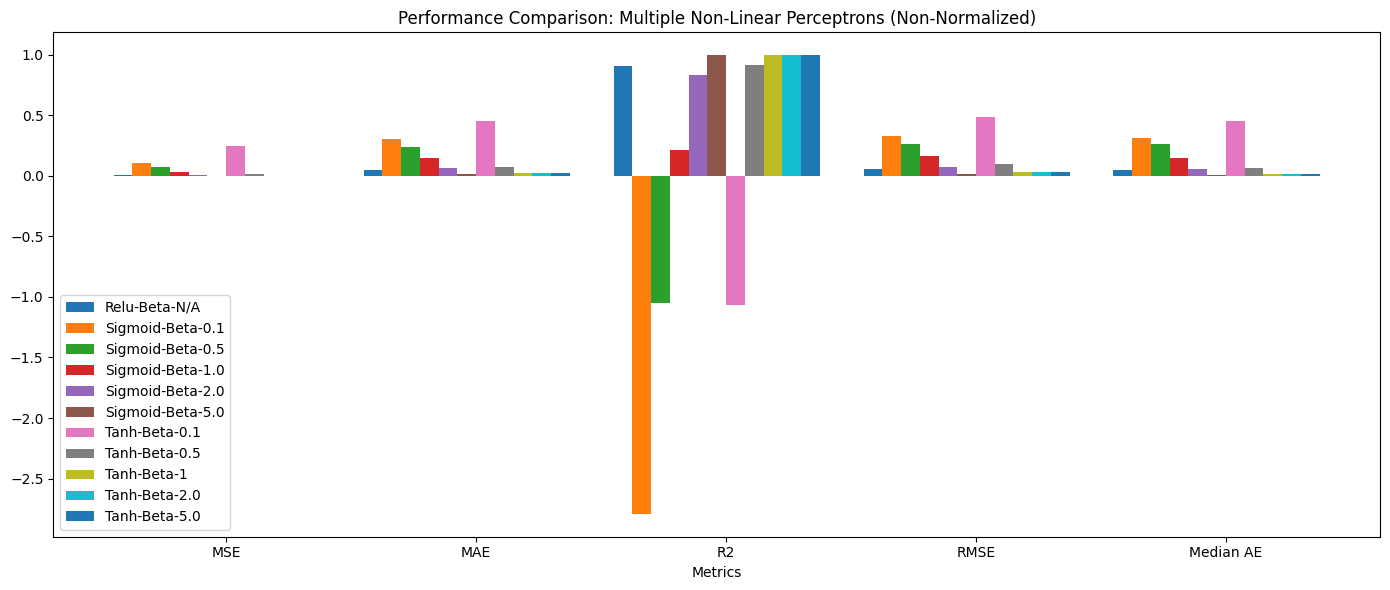

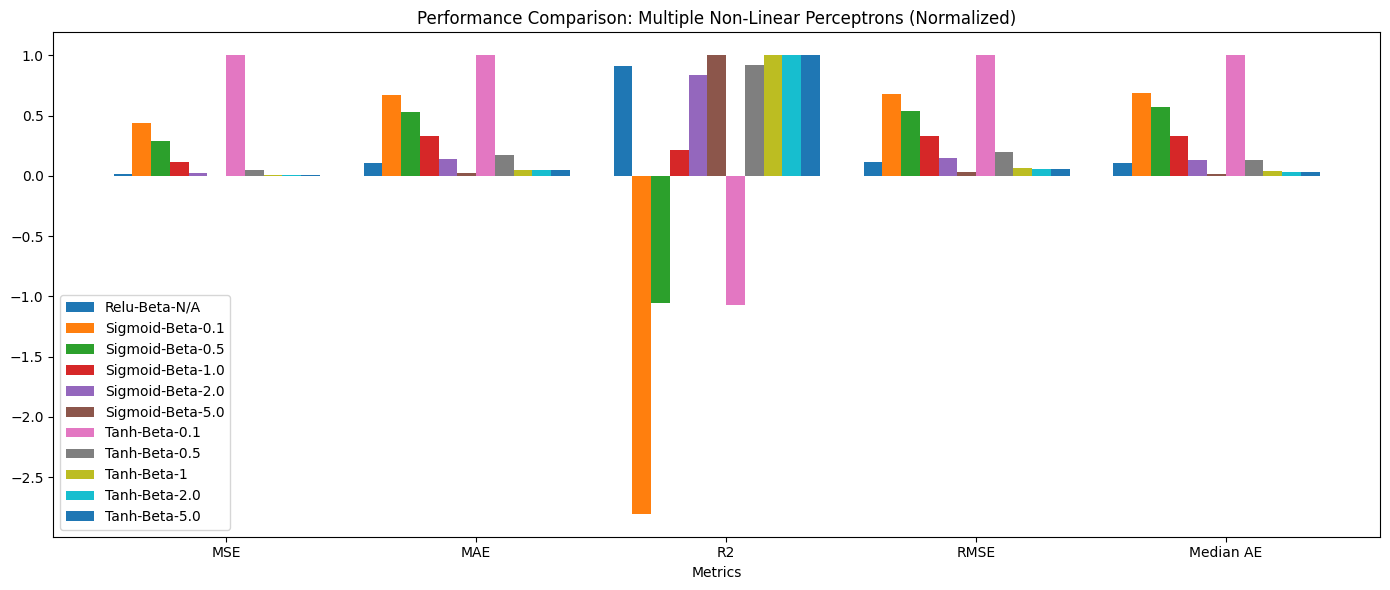

In [17]:
# Update metrics list to remove 'MAPE'
metrics = ['MSE', 'MAE', 'R2', 'RMSE', 'Median AE']  # Removed MAPE
key_map = {'MSE': 'mse', 'MAE': 'mae', 'R2': 'r2', 'RMSE': 'rmse', 'Median AE': 'med_ae'}

# Function to extract the beta value for sorting
def extract_beta(model_name):
    # Extract beta from model name (assumes format "Activation-Beta-X")
    try:
        beta_str = model_name.split('-Beta-')[-1]
        return float(beta_str) if beta_str != 'N/A' else float('inf')  # N/A becomes "infinity" for ReLU
    except ValueError:
        return float('inf')  # Handle any unexpected cases with a fallback

# Sort model names first by function, then by beta value
model_names_sorted = sorted(model_names, key=lambda x: (x.split('-')[0], extract_beta(x)))

# Calculate average metrics for each model, excluding ReLU models
average_metrics = {model: {key_map[metric]: np.mean([res[key_map[metric]] for res in results if res['model'] == model]) for metric in metrics} for model in model_names_sorted}

# Increase space between bars by adding a larger offset
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(metrics)) * 2  # Increasing the space between the label locations
width = 0.15  # The width of the bars

# Add all models to the graph
for i, model in enumerate(model_names_sorted):
    values = [average_metrics[model][key_map[metric]] for metric in metrics]
    ax.bar(x + i * width, values, width, label=model)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_title('Performance Comparison: Multiple Non-Linear Perceptrons (Non-Normalized)')
ax.set_xticks(x + width * (len(model_names_sorted) / 2))
ax.set_xticklabels(metrics)
ax.legend()

# Display the non-normalized graph
plt.tight_layout()
plt.show()

# Now normalize the metrics for a second graph
max_values = {metric: max([average_metrics[model][key_map[metric]] for model in model_names_sorted]) for metric in metrics}
normalized_metrics = {model: {key_map[metric]: average_metrics[model][key_map[metric]] / max_values[metric] for metric in metrics} for model in model_names_sorted}

# Increase space between bars for normalized graph
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(metrics)) * 2  # Again increasing the space between metrics

for i, model in enumerate(model_names_sorted):
    normalized_values = [normalized_metrics[model][key_map[metric]] for metric in metrics]
    ax.bar(x + i * width, normalized_values, width, label=model)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_title('Performance Comparison: Multiple Non-Linear Perceptrons (Normalized)')
ax.set_xticks(x + width * (len(model_names_sorted) / 2))
ax.set_xticklabels(metrics)
ax.legend()

# Display the normalized graph
plt.tight_layout()
plt.show()

